<a href="https://colab.research.google.com/github/VictorFrancheto/Complex_Network/blob/main/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando a biblioteca `graph-tool`(https://graph-tool.skewed.de)

---


In [1]:
!mkdir -p /etc/apt/keyrings; mkdir -p ~/.gnupg; chmod 700 ~/.gnupg
!gpg --no-default-keyring --keyring /etc/apt/keyrings/skewed.de.gpg --keyserver keyserver.ubuntu.com --recv-keys 612DEFB798507F25
!echo "deb [signed-by=/etc/apt/keyrings/skewed.de.gpg] https://downloads.skewed.de/apt $(lsb_release -s -c) main" > /etc/apt/sources.list.d/skewed.list
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

gpg: key 612DEFB798507F25: "Tiago de Paula Peixoto <tiago@skewed.de>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://downloads.skewed.de/apt jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Buildi

In [2]:
# O Colab usa uma instalação Python diferente da do sistema! Colaboração ruim! Precisamos de algumas soluções alternativas.
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages will be REMOVED:
  python3-cairo*
0 upgraded, 0 newly installed, 1 to remove and 43 not upgraded.
After this operation, 310 kB disk space will be freed.
(Reading database ... 131082 files and directories currently installed.)
Removing python3-cairo:amd64 (1.20.1-3build1) ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
pkg-config is already the newest version (0.29.2-1ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.
  Using cached pycairo-1.26.0-cp310-cp310-linux_x86_64.whl
  Attempting uninstall: pycairo
    Found existing installation: pycairo 1.26.0
    Uninstalling pycairo-1.26.0:
      Successfully uninstalled pycairo-1.26.0


### Agora podemos usar a ferramenta gráfica como qualquer outro módulo Python

In [3]:
import graph_tool.all as gt

# Classificação de redes complexa
---

Selecione 3 redes biológicas, 3 redes sociais e 3 redes tecnológicas desses endereços:

https://networks.skewed.de

http://konect.cc/networks/

https://icon.colorado.edu/

Faça a classificação das redes usando os modelos e medidas que aprendemos na aula.

Não se esqueça de selecionar o mesmo N e grau médio que a rede original na construção dos modelos.

Verifique qual o modelo mais adequado para cada rede.

**Hipótese:** Redes do mesmo tipo seguem o mesmo modelo. Verifique se essa hipótese é verdadeira.

**Bônus (não é obrigatório):** Identifique as principais diferenças entre os modelos. Isto é, quais medidas mais contribuem para que uma rede seja classificada como sendo do
modelo BA

Site utilizado: https://networks.skewed.de

### Redes Biologicas:
- fly_larva: https://networks.skewed.de/net/fly_larva
- human_brain: BNU1_0025880_1_DTI_DS01216
- blumenau_drug: https://networks.skewed.de/net/blumenau_drug

Vamos inicialmente trabalhar com a rede **fly_larva**.

Número de nós: 285
Número de arestas: 357


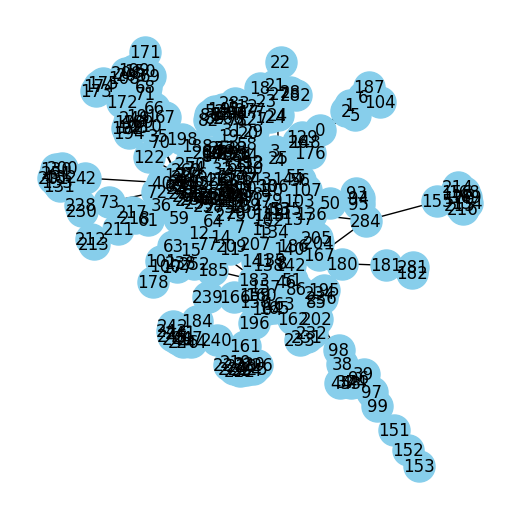

In [26]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import graph_tool.all as gt

# Importando a rede do Graph-tool

G_gt =gt.collection.ns["kidnappings"] #gt.collection.ns["fly_larva"]#gt.collection.ns["college_freshmen"]#gt.collection.ns["crime"] #gt.collection.ns["internet_as"] #gt.collection.ns["fly_larva"]

# Criando um grafo vazio do NetworkX
G_nx = nx.Graph()

# Adicionando arestas do grafo do Graph-tool para o grafo do NetworkX
for edge in G_gt.edges():
    G_nx.add_edge(edge.source(), edge.target())

# Removendo auto-laços
G_nx.remove_edges_from(nx.selfloop_edges(G_nx))

# Obtendo o maior componente conectado
Gcc = sorted(nx.connected_components(G_nx), key=len, reverse=True)
G_nx = G_nx.subgraph(Gcc[0])

# Convertendo rótulos de nós para inteiros
mapeamento = {node: idx for idx, node in enumerate(G_nx.nodes())}
G_nx = nx.relabel_nodes(G_nx, mapeamento)

N = len(G_nx)
M = G_nx.number_of_edges()
print("Número de nós:", N)
print("Número de arestas:", M)

#Calculando a posição dos nós usando o layout spring do NetworkX
pos = nx.spring_layout(G_nx)

#Desenhando o grafo
plt.figure(figsize=(5, 5))
nx.draw(G_nx, pos, node_color="skyblue", node_size=500, with_labels=True)
plt.show()


# Entropia de Shannon


In [27]:
import math

def degree_distribution(G):
    v_k = dict(G.degree())  #Obtém o dicionário dos graus de cada nó
    v_k = list(v_k.values())  #Obtemos apenas os valores dos graus
    v_k = np.array(v_k)
    max_k = np.max(v_k)  #Calcula o grau máximo
    min_k = np.min(v_k)  #Calcula o grau mínimo
    k_values = np.arange(0, max_k + 1)  #Possíveis valores de k
    P_k = np.zeros(max_k + 1)  # P(k)
    for k in v_k:
        P_k[k] = P_k[k] + 1  #Calcula a distribuição de graus
    P_k = P_k / sum(P_k)  #A soma dos elementos de P(k) deve ser igual a um
    return k_values, P_k

def shannon_entropy(G):
    k, Pk = degree_distribution(G)
    H = 0
    for p in Pk:
        if p > 0:
            H = H - p * math.log(p, 2)
    return H


def betweennes_(G):
    B = dict(nx.betweenness_centrality(G))
    B = list(B.values())
    return np.mean(B)

def neighbor_degree(G):
  return np.mean(list(nx.average_neighbor_degree(G).values()))

In [28]:
def measures(G):
    def momment_of_degree_distribution(G, m):
        M = 0
        N = len(G)
        for i in G.nodes:
            M = M + G.degree(i)**m
        M = M/N
        return M

    N = len(G)
    M = G.number_of_edges()
    v_k = dict(G.degree())
    v_k = list(v_k.values())
    v_k = np.array(v_k)
    k_1 = momment_of_degree_distribution(G, 1)
    k_2 = momment_of_degree_distribution(G, 2)
    variance = momment_of_degree_distribution(G, 2) - momment_of_degree_distribution(G, 1)**2
    av_cl = nx.average_clustering(G)
    l = nx.average_shortest_path_length(G)
    r = nx.degree_assortativity_coefficient(G)
    s = shannon_entropy(G)
    b = betweennes_(G)
    n= neighbor_degree(G)

    return  k_1, k_2, variance, av_cl, l, r, s, b, n


In [29]:
k_1, k_2, variance, av_cl, l, r, s, b, n = measures(G_nx)
X_net = [k_1, k_2, variance, av_cl, l, r, s, b, n ]
print(X_net)

[2.5052631578947366, 24.42105263157895, 18.14470914127424, 0.0, 6.127452433901656, -0.25871442354295, 2.1275404936376368, 0.018118206480217874, 15.0197465912559]


# Criando as redes

In [30]:
cl = ["ER","WS","BA", "WS__"]
#ER networks
X = []
y = []
n_nets = 60
av_degree = k_1
p = av_degree/(N-1)
for i in range(0, n_nets):
    GER = nx.gnp_random_graph(N, p, seed=None, directed=False)
    Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
    GER = GER.subgraph(Gcc[0])
    GER = nx.convert_node_labels_to_integers(GER, first_label=0)
    k_1, k_2, variance, av_cl, l, r, s, b, n = measures(GER)
    x = [k_1, k_2, variance, av_cl, l , r, s, b, n]
    X.append(x)
    y.append(0.0)

#WS networks
k = int(av_degree)
p = 0.1 #probability of rewiring #0.3
for i in range(0, n_nets):
    GWS = nx.watts_strogatz_graph(N, k, p, seed=None)
    Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
    GWS = GWS.subgraph(Gcc[0])
    GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)
    k_1, k_2, variance, av_cl, l, r, s, b, n = measures(GWS)
    x = [k_1, k_2, variance, av_cl, l, r, s, b, n]
    X.append(x)
    y.append(1.0)

#BA networks
m = int(av_degree/2)
for i in range(0, n_nets):
    GBA = nx.barabasi_albert_graph(N, m)
    Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
    GBA = GBA.subgraph(Gcc[0])
    GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
    k_1, k_2, variance, av_cl, l, r, s, b, n = measures(GWS)
    x = [k_1, k_2, variance, av_cl, l, r, s, b, n]
    X.append(x)
    y.append(2.0)

#WS__ networks
k = int(av_degree)
p = 0.3 #probability of rewiring #0.3
for i in range(0, n_nets):
    GWS__ = nx.watts_strogatz_graph(N, k, p, seed=None)
    Gcc = sorted(nx.connected_components(GWS__), key=len, reverse=True)
    GWS__ = GWS__.subgraph(Gcc[0])
    GWS__ = nx.convert_node_labels_to_integers(GWS__, first_label=0)
    k_1, k_2, variance, av_cl, l, r, s, b, n = measures(GWS__)
    x = [k_1, k_2, variance, av_cl, l, r, s, b, n]
    X.append(x)
    y.append(3.0)

# WG networks (Waxman)
alpha = 0.4  # Parâmetro alpha do modelo Waxman
beta = 0.1  # Parâmetro beta do modelo Waxman
for i in range(n_nets):
    GWG = nx.waxman_graph(N, alpha=alpha, beta=beta, domain=(0, 0, 1, 1), seed=None)
    Gcc = sorted(nx.connected_components(GWG), key=len, reverse=True)
    GWG = GWG.subgraph(Gcc[0])
    GWG = nx.convert_node_labels_to_integers(GWG, first_label=0)
    k_1, k_2, variance, av_cl, l, r, s, b, n = measures(GWG)
    x = [k_1, k_2, variance, av_cl, l, r, s, b, n]
    X.append(x)
    y.append(4.0)

In [31]:
X = np.array(X)
y = np.array(y)

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1,len(X_net))
X_net = scaler.transform(X_net)
print("Xnet:", X_net.shape)

k = 5
model = KNeighborsClassifier(n_neighbors=k, metric = "euclidean")
model.fit(X,y)
# faz a predição no conjunto de teste

Xnet: (1, 9)


KNeighborsClassifier(metric='euclidean')

In [33]:
y_pred = model.predict(X_net)
print("Classe:", cl[int(y_pred)])

Classe: ER


<ipython-input-33-e32985034b0a>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Classe:", cl[int(y_pred)])


In [34]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import graph_tool.all as gt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# Criando um modelo de regressão logística
model = LogisticRegression()
model.fit(X, y)

# Fazendo a predição no novo exemplo
y_pred = model.predict(X_net)
print("Classe:",  cl[int(y_pred)])


Classe: ER


<ipython-input-34-bc9c10717cf0>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Classe:",  cl[int(y_pred)])
